In [1]:
import numpy as np
import pandas as pd 
import os
import time
import random
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./

Cloning into 'yolov5'...
remote: Enumerating objects: 16656, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 16656 (delta 1), reused 5 (delta 0), pack-reused 16649
Receiving objects: 100% (16656/16656), 15.14 MiB | 33.99 MiB/s, done.
Resolving deltas: 100% (11441/11441), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 2.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-b

In [3]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('../input/car-object-detection/data/train_solution_bounding_boxes (1).csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   image   559 non-null    object 
 1   xmin    559 non-null    float64
 2   ymin    559 non-null    float64
 3   xmax    559 non-null    float64
 4   ymax    559 non-null    float64
dtypes: float64(4), object(1)
memory usage: 22.0+ KB
None


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [4]:
df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin']+df['xmax'])/2
df['y_center'] = (df['ymin']+df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center'] / img_w
df['y_center'] = df['y_center'] / img_h
df['w'] = df['w'] / img_w
df['h'] = df['h'] / img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [5]:
index = list(set(df.image_id))
image = random.choice(index)
print(f"Image ID: {image}")
img = cv2.imread(f'../input/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_26400


(380, 676, 3)

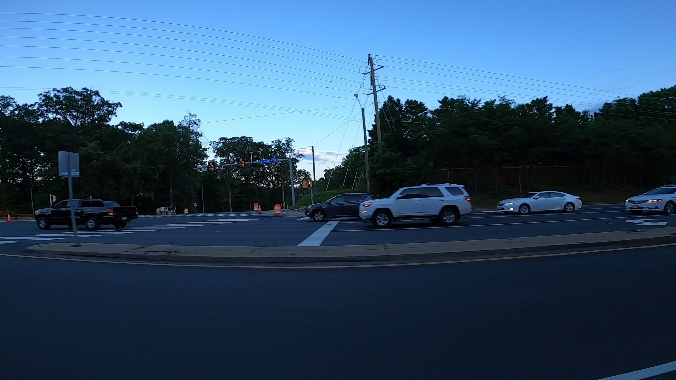

In [6]:
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

## Training

In [7]:
source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5] # 5-fold cross-validation
        for name,mini in tqdm(df.groupby('image_id')): # tqdm for progress bar
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            # label 
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values # classes, x_center, y_center, w, h
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            # image 
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/kaggle/input/car-object-detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/355 [00:00<?, ?it/s]

----
## Train and Test Only Find Car

In [8]:
if not os.path.exists("/kaggle/working/yolov5"):
    # If not, clone the YOLOv5 repository
    !git clone https://github.com/ultralytics/yolov5

In [9]:
!pip install -r requirements.txt

In [10]:
import yaml 

data = {
    'train': '/tmp/convertor/fold0/images/train2017/',
    'val': '/tmp/convertor/fold0/images/train2017/',
    'nc':1,
    'names':['car']
}

filename = '/kaggle/working/my_dataset.yaml'

with open(filename, 'w') as file:
    yaml.dump(data, file)

In [11]:
!git clone https://github.com/ultralytics/yolov5

fatal: destination path 'yolov5' already exists and is not an empty directory.


In [12]:
cd /kaggle/working

/kaggle/working


In [13]:
ls

__notebook__.ipynb  my_dataset.yaml  requirements.txt  yolov5/


In [14]:
cd /kaggle/working/yolov5

/kaggle/working/yolov5


In [15]:
!mv /kaggle/working/my_dataset.yaml /kaggle/working/yolov5

In [16]:
!python train.py --img 640 --batch 16 --epochs 20 --data my_dataset.yaml --weights yolov5s.pt --cache 

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-05 08:04:38.536383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 08:04:38.536506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 08:04:38.702662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

In [17]:
!python val.py --weights runs/train/exp/weights/best.pt --data my_dataset.yaml --img 640

val: data=my_dataset.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /tmp/convertor/fold0/labels/train2017.cache... 284 images, 0 backg
                 Class     Images  Instances          P          R      mAP50   
                   all        284        445      0.976      0.993      0.992      0.675
Speed: 0.3ms pre-process, 3.6ms inference, 3.4ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp


In [18]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['runs/train/exp/weights/best.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-318-gc0380fd8 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 55.7ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 7.5ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid

In [19]:
my_predicted_files = []
for (dirpath, dirnames, filenames) in os.walk('runs/detect/exp'):
    my_predicted_files.extend(filenames)

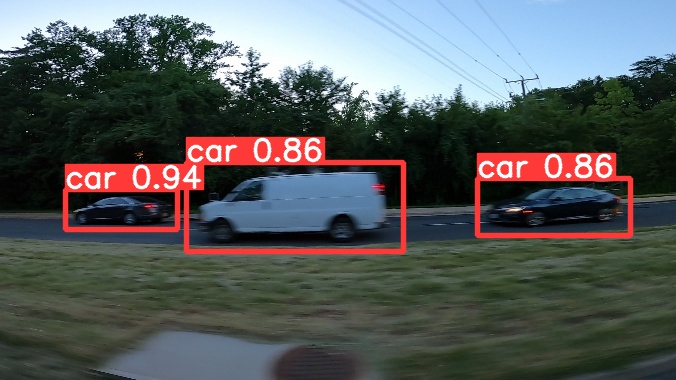

In [20]:
Image(filename=f'runs/detect/exp/{random.choice(my_predicted_files)}')

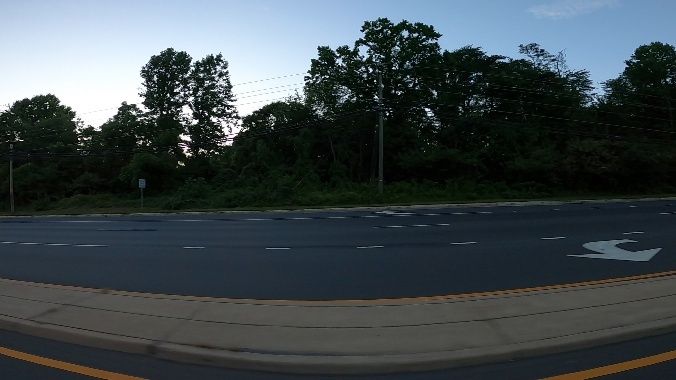

In [21]:
Image(filename=f'runs/detect/exp/{random.choice(my_predicted_files)}')

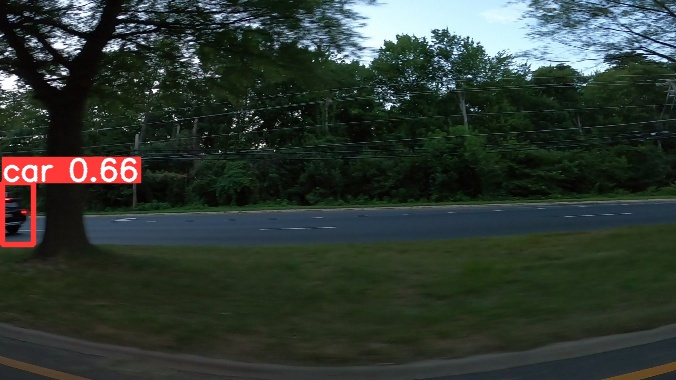

In [22]:
Image(filename=f'runs/detect/exp/{random.choice(my_predicted_files)}')

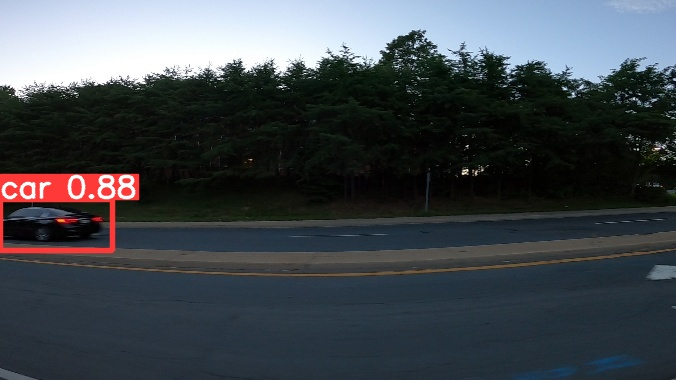

In [23]:
Image(filename=f'runs/detect/exp/{random.choice(my_predicted_files)}')

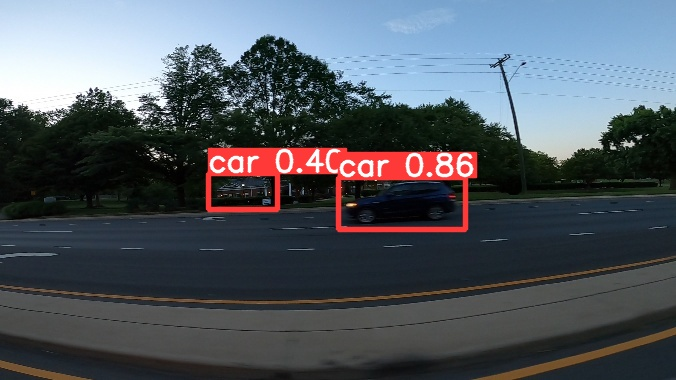

In [24]:
Image(filename=f'runs/detect/exp/{random.choice(my_predicted_files)}')

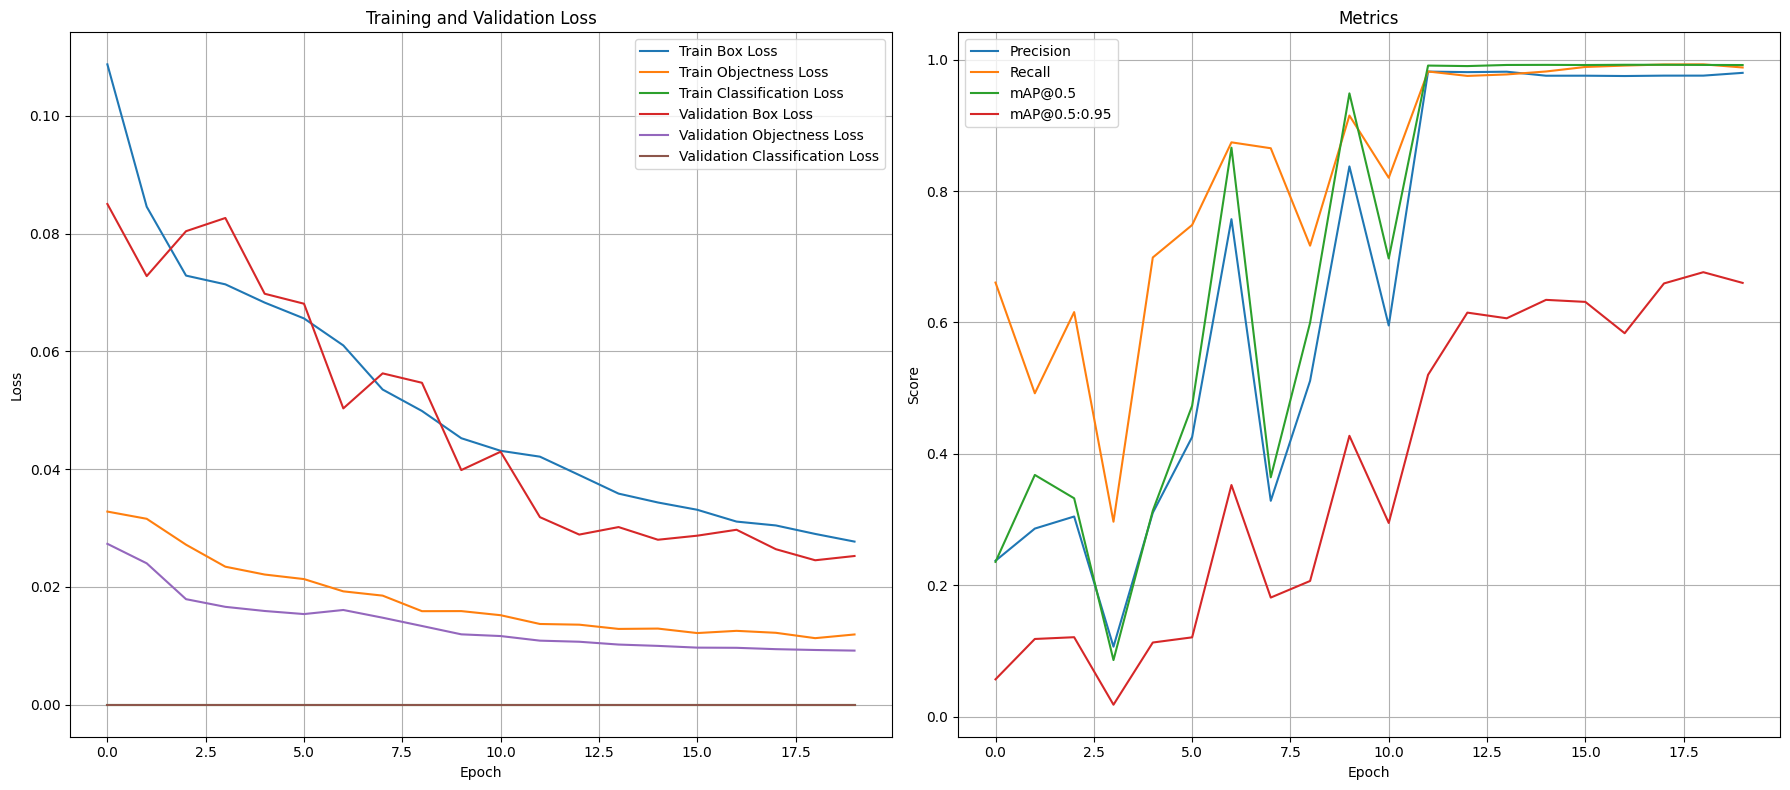

In [25]:
results_path = 'runs/train/exp/results.csv'  # Adjust path as necessary
results = pd.read_csv(results_path)
results.columns = results.columns.str.strip()

# Plot
fig, axs = plt.subplots(1, 2, figsize=(18, 8))  # Adjust figsize as needed
axs[0].plot(results['epoch'], results['train/box_loss'], label='Train Box Loss')
axs[0].plot(results['epoch'], results['train/obj_loss'], label='Train Objectness Loss')
axs[0].plot(results['epoch'], results['train/cls_loss'], label='Train Classification Loss')
axs[0].plot(results['epoch'], results['val/box_loss'], label='Validation Box Loss')
axs[0].plot(results['epoch'], results['val/obj_loss'], label='Validation Objectness Loss')
axs[0].plot(results['epoch'], results['val/cls_loss'], label='Validation Classification Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].legend()
axs[0].grid()

axs[1].plot(results['epoch'], results['metrics/precision'], label='Precision')
axs[1].plot(results['epoch'], results['metrics/recall'], label='Recall')
axs[1].plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
axs[1].plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Score')
axs[1].set_title('Metrics')
axs[1].legend()
axs[1].grid()

# Show the plots
plt.tight_layout()
plt.show()